### Import dataset and put into dataloader

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
import os
import glob

torch.manual_seed(43)

# define parameters
epoch_num = 50
learning_rate = 0.001

batchSize = 16

subset_size = 5500
val_size = 500
test_size = 1000

model_name = "MLP_v1_001_last_relu"


# transform
transform_ = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5))
    ])

# split and load datasets
dataset = torchvision.datasets.CIFAR10(root='../src_MLP/data', train=True, download=False, transform=transform_)
_size = len(dataset) - subset_size
subset, _ = random_split(dataset, [subset_size, _size])

train_size = len(subset) - val_size
trainSet, validSet = random_split(subset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='../src_MLP/data', train=False, download=False, transform=transform_)
_size = len(test_dataset) - test_size
testSet, _ = random_split(test_dataset, [test_size, _size])
testloader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=True, num_workers=2)

print("trainSet size: ", len(trainSet))
print("validSet size: ", len(validSet))
print("testset size: ", len(testSet))

fixed_trainloader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize, shuffle=False, num_workers=2)
fixed_validloader = torch.utils.data.DataLoader(validSet, batch_size=batchSize, shuffle=False, num_workers=2)
fixed_testloader = torch.utils.data.DataLoader(testSet, batch_size=batchSize, shuffle=False, num_workers=2)
print("trainloader size: ", len(trainloader))
print("validloader size: ", len(validloader))
print("testloader size: ", len(testloader))

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

trainSet size:  5000
validSet size:  500
testset size:  1000
trainloader size:  313
validloader size:  32
testloader size:  63
cuda:0


### Pre-processing: Convert all rgb images to gray images

images_color shape:  torch.Size([16, 3, 32, 32])


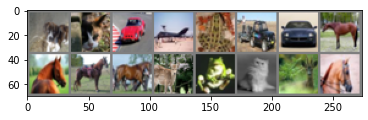

images_gray shape:  torch.Size([16, 1, 32, 32])


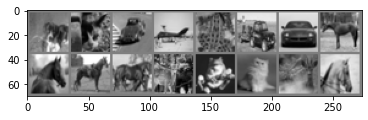

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# create folders
if not os.path.exists('./plot'):
    os.mkdir('./plot/')
if not os.path.exists('./plot/'+model_name+'/'):
    os.mkdir('./plot/'+model_name+'/')
if not os.path.exists('./plot/'+model_name+'/running_inference_train/'):
    os.mkdir('./plot/'+model_name+'/running_inference_train/')
if not os.path.exists('./plot/'+model_name+'/running_inference_valid/'):
    os.mkdir('./plot/'+model_name+'/running_inference_valid/')
if not os.path.exists('./plot/'+model_name+'/inference/'):
    os.mkdir('./plot/'+model_name+'/inference/')

    
if not os.path.exists('./saved_model'):
    os.mkdir('./saved_model/')

# functions to show an image
def imshow(img, name=""):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) 
    plt.savefig('plot/'+model_name+'/'+name+'.png')
    plt.show()

# get some random training images
images_color, labels = next(iter(trainloader))

# function to convert a rgb_img to gray_img
def rgb2gray(img):
    rgb_img = img.transpose(1,2,0)
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2GRAY)
    return gray_img

# function to convert a batch of rgb images to gray images
def rgb2gray_batch(images):
    rgb_images = np.array(images)    
    
    gray_images = []
    for i in range(rgb_images.shape[0]):
        img = rgb_images[i]
        gray_img = rgb2gray(img)
        gray_images.append(gray_img)
    
    gray_images = np.array(gray_images)
    gray_images = torch.from_numpy(gray_images)
    return gray_images
        
images_gray = rgb2gray_batch(images_color)

# show images
print("images_color shape: ", images_color.shape)
imshow(torchvision.utils.make_grid(images_color), name="color_sample")
images_gray = images_gray.reshape(batchSize,1,32,32)
print("images_gray shape: ", images_gray.shape)
imshow(torchvision.utils.make_grid(images_gray), name="gray_sample")

### Define the MLP network

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class MLP_net(nn.Module):
    def __init__(self):
        # Input layer is 1024, since CIFAR-10 gray_image is 1x32x32
        # Output layer is 3072, since CIFAR-10 gray_image is 3x32x32
        super(MLP_net, self).__init__()
    
        self.layers = nn.Sequential(
            nn.Linear(1024, 3072),
            nn.BatchNorm1d(3072),
            nn.Sigmoid(),
            
            nn.Linear(3072, 3072),
            nn.BatchNorm1d(3072),
            nn.ReLU()
        )


#         self.layers = nn.Sequential(
#             nn.Linear(1024, 1024),
#             nn.BatchNorm1d(1024),
#             nn.Sigmoid(),

#             nn.Linear(1024, 3072),
#             nn.BatchNorm1d(3072),
#             #nn.Sigmoid()
#         )
        
    def forward(self, x):
        # convert tensor (4, 1, 32, 32) --> (4, 1*32*32)
        x = x.view(x.size(0), -1)
        x = self.layers(x)
        
        return x

model = MLP_net().to(device)

print("GPU: ", next(model.parameters()).is_cuda)

model_path = "./saved_model/"+model_name + ".pt"
if os.path.exists(model_path):
    print("Continue training from the saved model")
    model.load_state_dict(torch.load(model_path))

GPU:  True


### Define the loss function and optimizer

In [4]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

# criterion
criterion = nn.MSELoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate) #betas=(0.9, 0.999), eps=1e-08, weight_decay=0
    # optimizer = optim.SGD(mlp_net.parameters(), lr=0.0001, momentum=0.9)

# load previous trained model 
if os.path.exists(model_path):
    print("Continue training from the saved model")
    model.load_state_dict(torch.load(model_path))
    
# Writer will output to ./runs/ directory by default
writer = SummaryWriter("./runs/"+model_name+"/")
# plot_writer = SummaryWriter("./runs_plot/"+model_name+"/")

# Write current finished epoch num to a txt file
if not os.path.exists("./runs/"+model_name+"/epoch.txt"):
    fileEpoch = open("./runs/"+model_name+"/epoch.txt","w") 
    fileEpoch.write("-1")
    fileEpoch.close()

# Read previous finished epoch num from a txt file
fileEpoch = open("./runs/"+model_name+"/epoch.txt","r")
prev_epoch = int(fileEpoch.read())+1
print("previous finished epoch nums: ", prev_epoch)
fileEpoch.close()

previous finished epoch nums:  0


In [5]:
def make_grid(loaderName, k, prefix):
    print(("inference on " + prefix + ":"))
    
    images_color, _ = next(iter(loaderName))
#     print("images_color: ", images_color.shape)
    images_color_show = images_color.reshape(batchSize,3,32,32)
#     imshow(torchvision.utils.make_grid(images_color_show.detach()), name="inference_Train_color")

    images_gray = rgb2gray_batch(images_color)
#     print("images_gray: ", images_gray.shape)
    images_gray = images_gray.reshape(batchSize,1,32,32)
#     imshow(torchvision.utils.make_grid(images_gray.detach()), name="inference_Train_gray")

    model.eval()
    with torch.no_grad():
        # run inference on the network
        images_gray = images_gray.to(device)
        outputs = model(images_gray)
        outputs = outputs.reshape(batchSize,3,32,32)
        outputs = outputs.to("cpu")
    
    # show the gray & output images in grid
    images_gray = images_gray.to("cpu")
    images_gray = torch.cat((images_gray, images_gray, images_gray), 1)
    merged_out = torch.cat((images_gray, outputs),0)
    imshow(torchvision.utils.make_grid(merged_out.detach()), name="running_inference_"+ prefix + "/trainData_"+str(format(k, '04d')))
    
#     grid_output = torchvision.utils.make_grid(outputs.detach())
#     plot_writer.add_image(str(loaderName), grid_output, k)

### Train the network

Start training from Epoch:  1
Training Mode...
[1,    50] train loss: 0.438
[1,   100] train loss: 0.359
[1,   150] train loss: 0.305
[1,   200] train loss: 0.262
[1,   250] train loss: 0.241
[1,   300] train loss: 0.226
Validation Mode...
[1, _] validation loss: 0.208
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


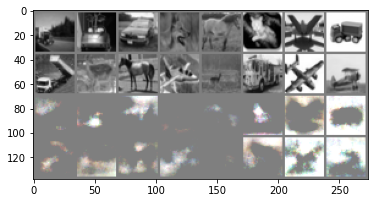

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


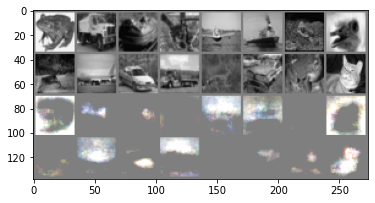

[1, _] epoch train loss: 0.302
[1, _] epoch valid loss: 0.207
Training Mode...
[2,    50] train loss: 0.198
[2,   100] train loss: 0.195
[2,   150] train loss: 0.199
[2,   200] train loss: 0.188
[2,   250] train loss: 0.179
[2,   300] train loss: 0.182
Validation Mode...
[2, _] validation loss: 0.177
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


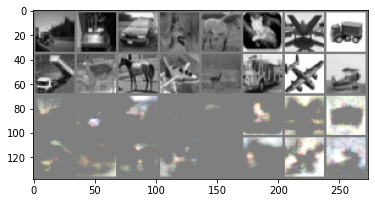

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


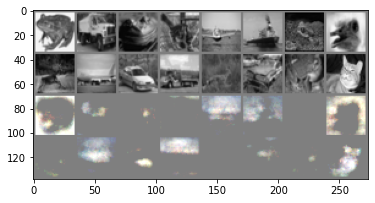

[2, _] epoch train loss: 0.190
[2, _] epoch valid loss: 0.179
Training Mode...
[3,    50] train loss: 0.181
[3,   100] train loss: 0.177
[3,   150] train loss: 0.179
[3,   200] train loss: 0.171
[3,   250] train loss: 0.179
[3,   300] train loss: 0.171
Validation Mode...
[3, _] validation loss: 0.178
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


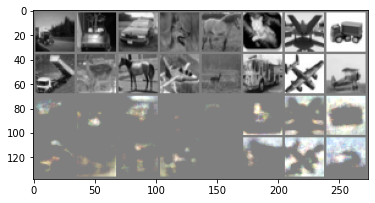

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


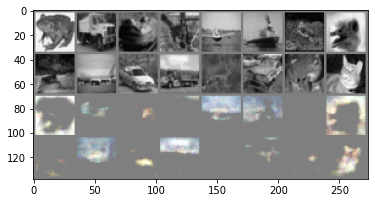

[3, _] epoch train loss: 0.176
[3, _] epoch valid loss: 0.177
Training Mode...
[4,    50] train loss: 0.177
[4,   100] train loss: 0.175
[4,   150] train loss: 0.174
[4,   200] train loss: 0.168
[4,   250] train loss: 0.169
[4,   300] train loss: 0.177
Validation Mode...
[4, _] validation loss: 0.174
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


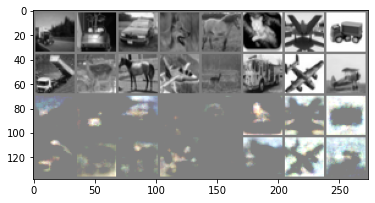

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


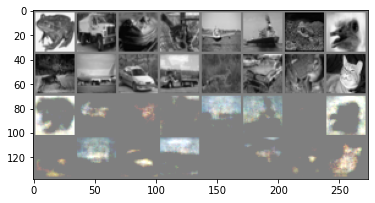

[4, _] epoch train loss: 0.173
[4, _] epoch valid loss: 0.175
Training Mode...
[5,    50] train loss: 0.169
[5,   100] train loss: 0.166
[5,   150] train loss: 0.172
[5,   200] train loss: 0.175
[5,   250] train loss: 0.175
[5,   300] train loss: 0.173
Validation Mode...
[5, _] validation loss: 0.172
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


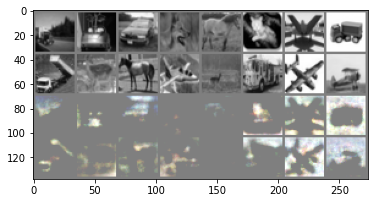

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


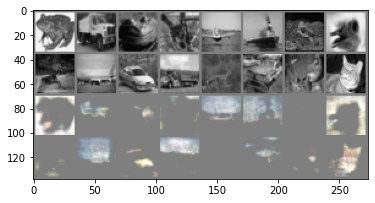

[5, _] epoch train loss: 0.172
[5, _] epoch valid loss: 0.173
Training Mode...
[6,    50] train loss: 0.173
[6,   100] train loss: 0.164
[6,   150] train loss: 0.175
[6,   200] train loss: 0.169
[6,   250] train loss: 0.176
[6,   300] train loss: 0.167
Validation Mode...
[6, _] validation loss: 0.172
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


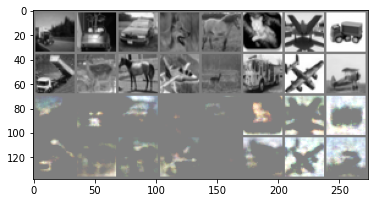

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


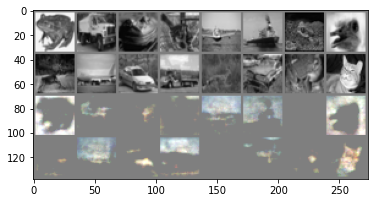

[6, _] epoch train loss: 0.170
[6, _] epoch valid loss: 0.172
Training Mode...
[7,    50] train loss: 0.165
[7,   100] train loss: 0.169
[7,   150] train loss: 0.170
[7,   200] train loss: 0.170
[7,   250] train loss: 0.166
[7,   300] train loss: 0.172
Validation Mode...
[7, _] validation loss: 0.170
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


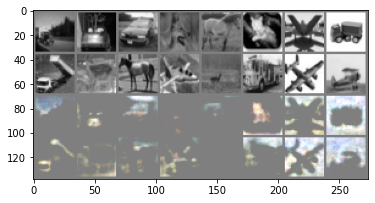

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


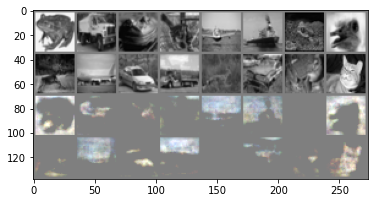

[7, _] epoch train loss: 0.169
[7, _] epoch valid loss: 0.172
Training Mode...
[8,    50] train loss: 0.169
[8,   100] train loss: 0.171
[8,   150] train loss: 0.169
[8,   200] train loss: 0.169
[8,   250] train loss: 0.165
[8,   300] train loss: 0.167
Validation Mode...
[8, _] validation loss: 0.169
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


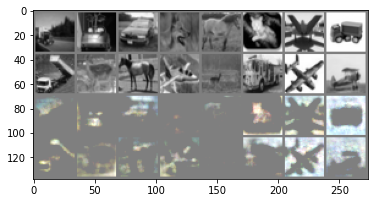

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


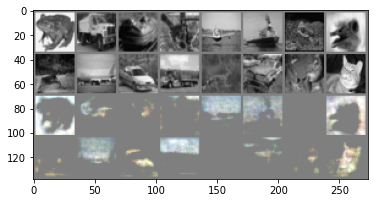

[8, _] epoch train loss: 0.168
[8, _] epoch valid loss: 0.171
Training Mode...
[9,    50] train loss: 0.168
[9,   100] train loss: 0.166
[9,   150] train loss: 0.167
[9,   200] train loss: 0.168
[9,   250] train loss: 0.164
[9,   300] train loss: 0.170
Validation Mode...
[9, _] validation loss: 0.171
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


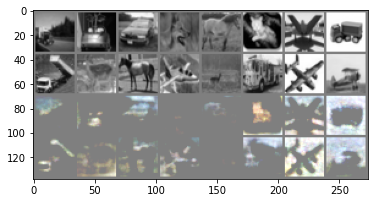

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


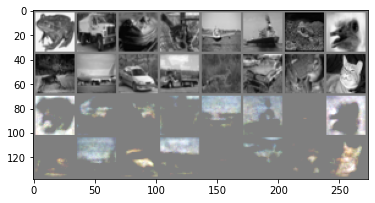

[9, _] epoch train loss: 0.167
[9, _] epoch valid loss: 0.170
Training Mode...
[10,    50] train loss: 0.164
[10,   100] train loss: 0.168
[10,   150] train loss: 0.164
[10,   200] train loss: 0.171
[10,   250] train loss: 0.164
[10,   300] train loss: 0.168
Validation Mode...
[10, _] validation loss: 0.169
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


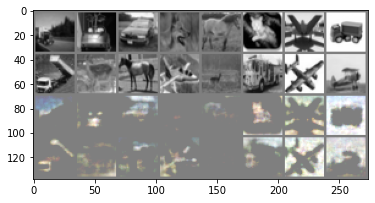

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


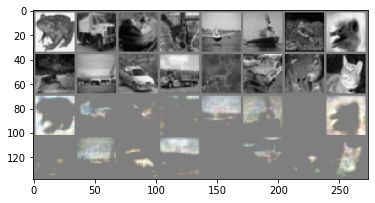

[10, _] epoch train loss: 0.166
[10, _] epoch valid loss: 0.170
Training Mode...
[11,    50] train loss: 0.174
[11,   100] train loss: 0.160
[11,   150] train loss: 0.167
[11,   200] train loss: 0.164
[11,   250] train loss: 0.167
[11,   300] train loss: 0.162
Validation Mode...
[11, _] validation loss: 0.168
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


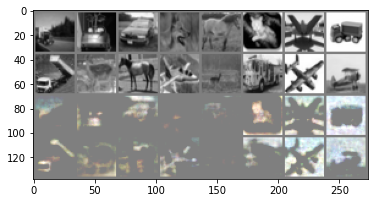

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


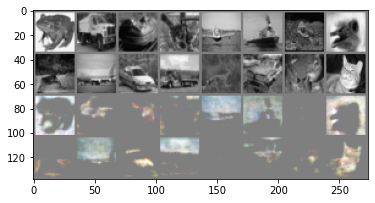

[11, _] epoch train loss: 0.166
[11, _] epoch valid loss: 0.169
Training Mode...
[12,    50] train loss: 0.162
[12,   100] train loss: 0.168
[12,   150] train loss: 0.170
[12,   200] train loss: 0.159
[12,   250] train loss: 0.170
[12,   300] train loss: 0.165
Validation Mode...
[12, _] validation loss: 0.168
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


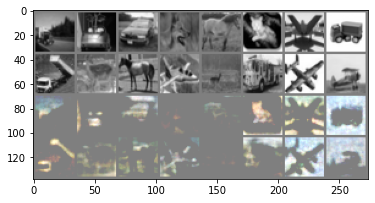

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


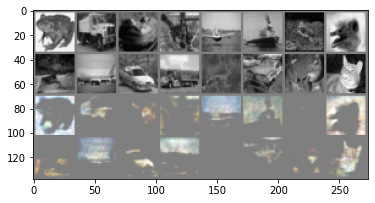

[12, _] epoch train loss: 0.165
[12, _] epoch valid loss: 0.169
Training Mode...
[13,    50] train loss: 0.160
[13,   100] train loss: 0.169
[13,   150] train loss: 0.161
[13,   200] train loss: 0.168
[13,   250] train loss: 0.167
[13,   300] train loss: 0.168
Validation Mode...
[13, _] validation loss: 0.168
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


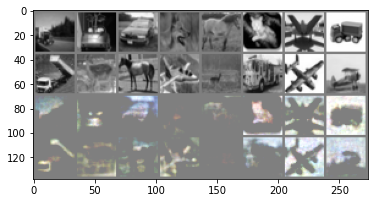

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


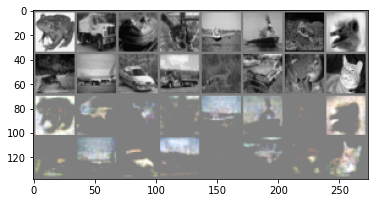

[13, _] epoch train loss: 0.165
[13, _] epoch valid loss: 0.168
Training Mode...
[14,    50] train loss: 0.166
[14,   100] train loss: 0.160
[14,   150] train loss: 0.165
[14,   200] train loss: 0.162
[14,   250] train loss: 0.161
[14,   300] train loss: 0.171
Validation Mode...
[14, _] validation loss: 0.169
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


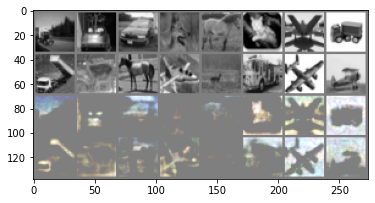

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


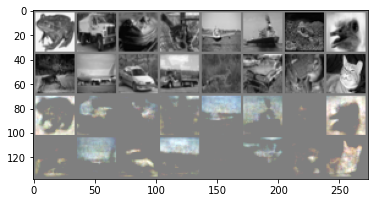

[14, _] epoch train loss: 0.164
[14, _] epoch valid loss: 0.168
Training Mode...
[15,    50] train loss: 0.162
[15,   100] train loss: 0.160
[15,   150] train loss: 0.170
[15,   200] train loss: 0.159
[15,   250] train loss: 0.164
[15,   300] train loss: 0.167
Validation Mode...
[15, _] validation loss: 0.168
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


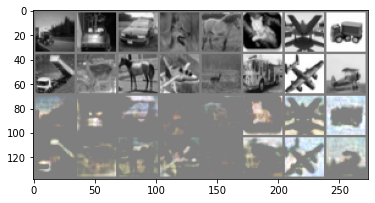

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


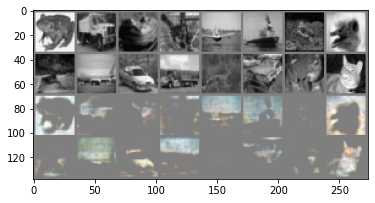

[15, _] epoch train loss: 0.164
[15, _] epoch valid loss: 0.168
Training Mode...
[16,    50] train loss: 0.161
[16,   100] train loss: 0.160
[16,   150] train loss: 0.163
[16,   200] train loss: 0.166
[16,   250] train loss: 0.161
[16,   300] train loss: 0.167
Validation Mode...
[16, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


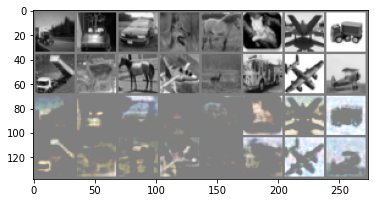

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


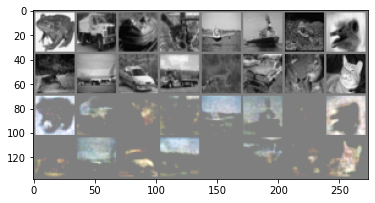

[16, _] epoch train loss: 0.163
[16, _] epoch valid loss: 0.167
Training Mode...
[17,    50] train loss: 0.168
[17,   100] train loss: 0.163
[17,   150] train loss: 0.158
[17,   200] train loss: 0.163
[17,   250] train loss: 0.159
[17,   300] train loss: 0.164
Validation Mode...
[17, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


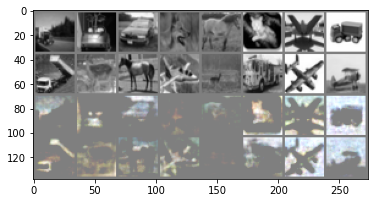

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


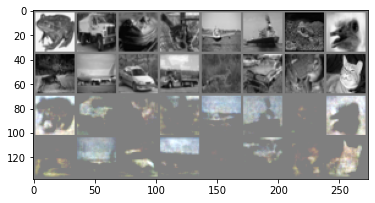

[17, _] epoch train loss: 0.163
[17, _] epoch valid loss: 0.167
Training Mode...
[18,    50] train loss: 0.165
[18,   100] train loss: 0.159
[18,   150] train loss: 0.168
[18,   200] train loss: 0.160
[18,   250] train loss: 0.160
[18,   300] train loss: 0.164
Validation Mode...
[18, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


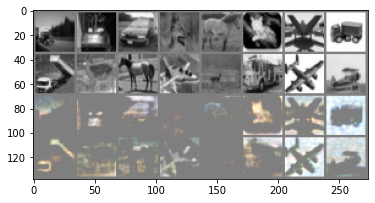

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


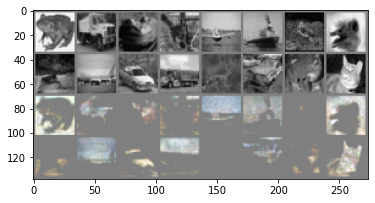

[18, _] epoch train loss: 0.163
[18, _] epoch valid loss: 0.166
Training Mode...
[19,    50] train loss: 0.164
[19,   100] train loss: 0.166
[19,   150] train loss: 0.164
[19,   200] train loss: 0.158
[19,   250] train loss: 0.157
[19,   300] train loss: 0.166
Validation Mode...
[19, _] validation loss: 0.167
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


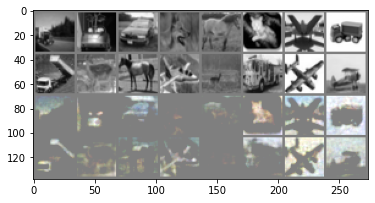

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


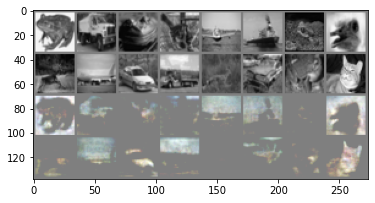

[19, _] epoch train loss: 0.162
[19, _] epoch valid loss: 0.167
Training Mode...
[20,    50] train loss: 0.161
[20,   100] train loss: 0.159
[20,   150] train loss: 0.166
[20,   200] train loss: 0.163
[20,   250] train loss: 0.162
[20,   300] train loss: 0.162
Validation Mode...
[20, _] validation loss: 0.166
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


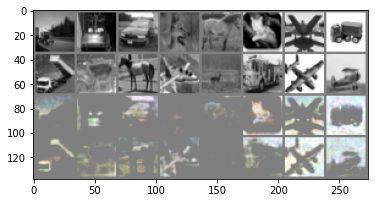

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


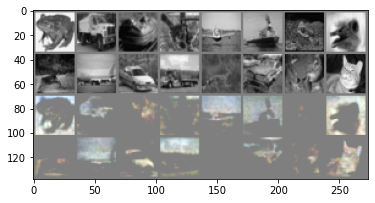

[20, _] epoch train loss: 0.162
[20, _] epoch valid loss: 0.166
Training Mode...
[21,    50] train loss: 0.169
[21,   100] train loss: 0.159
[21,   150] train loss: 0.160
[21,   200] train loss: 0.162
[21,   250] train loss: 0.156
[21,   300] train loss: 0.164
Validation Mode...
[21, _] validation loss: 0.166
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


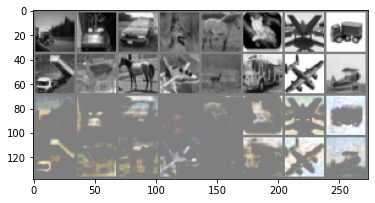

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


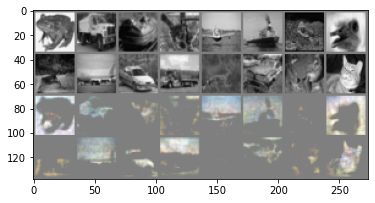

[21, _] epoch train loss: 0.162
[21, _] epoch valid loss: 0.167
Training Mode...
[22,    50] train loss: 0.162
[22,   100] train loss: 0.168
[22,   150] train loss: 0.156
[22,   200] train loss: 0.158
[22,   250] train loss: 0.164
[22,   300] train loss: 0.162
Validation Mode...
[22, _] validation loss: 0.166
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


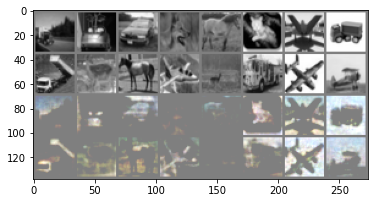

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


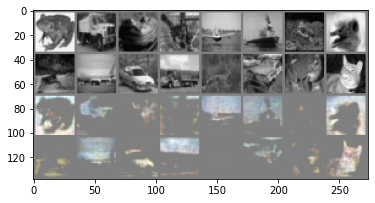

[22, _] epoch train loss: 0.161
[22, _] epoch valid loss: 0.166
Training Mode...
[23,    50] train loss: 0.157
[23,   100] train loss: 0.162
[23,   150] train loss: 0.158
[23,   200] train loss: 0.162
[23,   250] train loss: 0.167
[23,   300] train loss: 0.164
Validation Mode...
[23, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


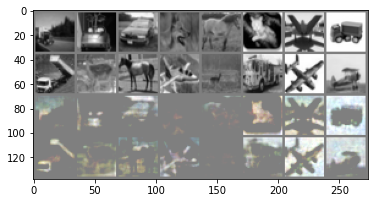

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


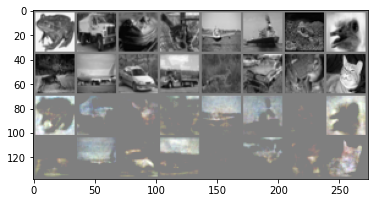

[23, _] epoch train loss: 0.161
[23, _] epoch valid loss: 0.166
Training Mode...
[24,    50] train loss: 0.156
[24,   100] train loss: 0.162
[24,   150] train loss: 0.162
[24,   200] train loss: 0.164
[24,   250] train loss: 0.162
[24,   300] train loss: 0.163
Validation Mode...
[24, _] validation loss: 0.167
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


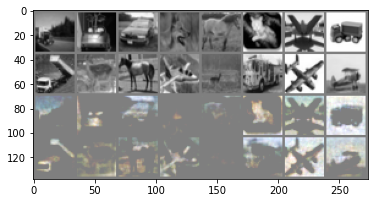

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


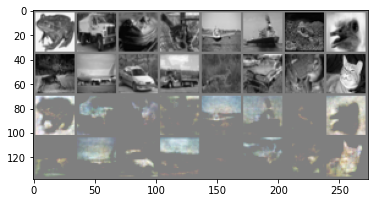

[24, _] epoch train loss: 0.161
[24, _] epoch valid loss: 0.167
Training Mode...
[25,    50] train loss: 0.162
[25,   100] train loss: 0.155
[25,   150] train loss: 0.161
[25,   200] train loss: 0.166
[25,   250] train loss: 0.161
[25,   300] train loss: 0.161
Validation Mode...
[25, _] validation loss: 0.166
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


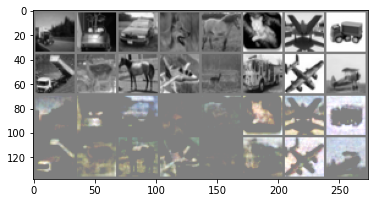

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


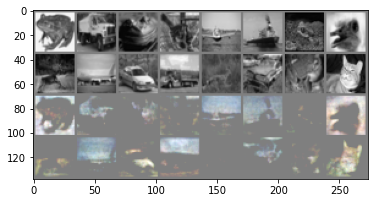

[25, _] epoch train loss: 0.161
[25, _] epoch valid loss: 0.166
Training Mode...
[26,    50] train loss: 0.158
[26,   100] train loss: 0.161
[26,   150] train loss: 0.162
[26,   200] train loss: 0.158
[26,   250] train loss: 0.160
[26,   300] train loss: 0.166
Validation Mode...
[26, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


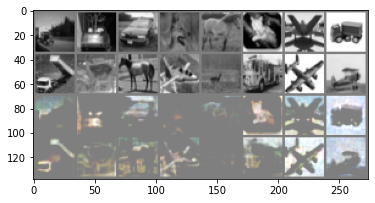

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


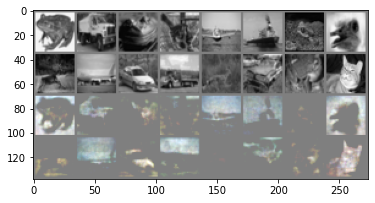

[26, _] epoch train loss: 0.161
[26, _] epoch valid loss: 0.166
Training Mode...
[27,    50] train loss: 0.165
[27,   100] train loss: 0.156
[27,   150] train loss: 0.161
[27,   200] train loss: 0.164
[27,   250] train loss: 0.160
[27,   300] train loss: 0.161
Validation Mode...
[27, _] validation loss: 0.166
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


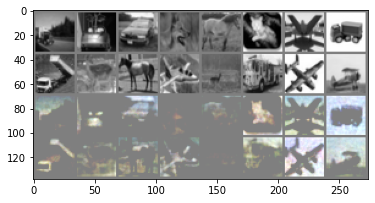

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


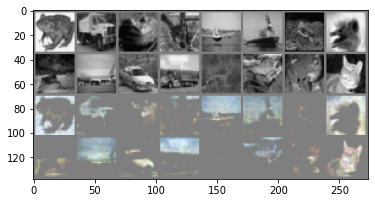

[27, _] epoch train loss: 0.161
[27, _] epoch valid loss: 0.166
Training Mode...
[28,    50] train loss: 0.160
[28,   100] train loss: 0.157
[28,   150] train loss: 0.164
[28,   200] train loss: 0.159
[28,   250] train loss: 0.156
[28,   300] train loss: 0.165
Validation Mode...
[28, _] validation loss: 0.169
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


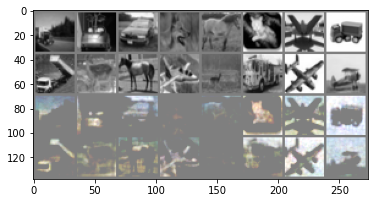

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


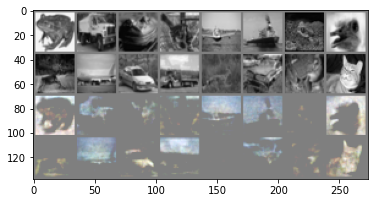

[28, _] epoch train loss: 0.160
[28, _] epoch valid loss: 0.166
Training Mode...
[29,    50] train loss: 0.166
[29,   100] train loss: 0.157
[29,   150] train loss: 0.164
[29,   200] train loss: 0.154
[29,   250] train loss: 0.167
[29,   300] train loss: 0.152
Validation Mode...
[29, _] validation loss: 0.164
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


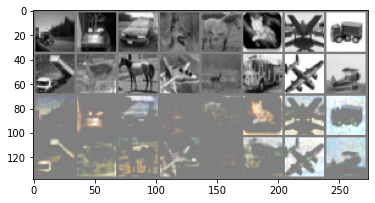

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


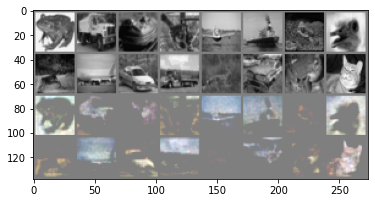

[29, _] epoch train loss: 0.160
[29, _] epoch valid loss: 0.166
Training Mode...
[30,    50] train loss: 0.159
[30,   100] train loss: 0.153
[30,   150] train loss: 0.161
[30,   200] train loss: 0.164
[30,   250] train loss: 0.160
[30,   300] train loss: 0.167
Validation Mode...
[30, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


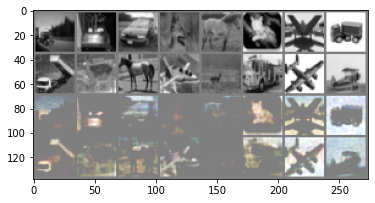

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


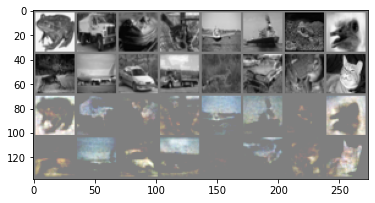

[30, _] epoch train loss: 0.160
[30, _] epoch valid loss: 0.166
Training Mode...
[31,    50] train loss: 0.159
[31,   100] train loss: 0.160
[31,   150] train loss: 0.163
[31,   200] train loss: 0.155
[31,   250] train loss: 0.158
[31,   300] train loss: 0.161
Validation Mode...
[31, _] validation loss: 0.170
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


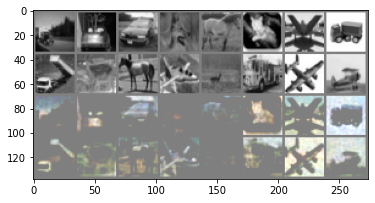

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


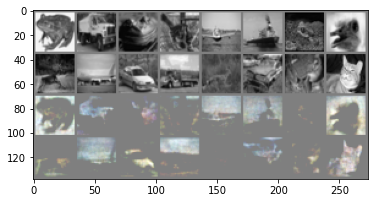

[31, _] epoch train loss: 0.159
[31, _] epoch valid loss: 0.166
Training Mode...
[32,    50] train loss: 0.165
[32,   100] train loss: 0.148
[32,   150] train loss: 0.156
[32,   200] train loss: 0.164
[32,   250] train loss: 0.161
[32,   300] train loss: 0.164
Validation Mode...
[32, _] validation loss: 0.164
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


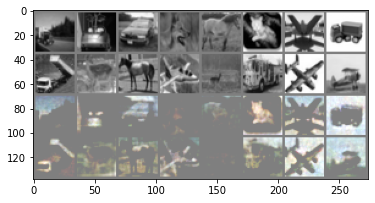

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


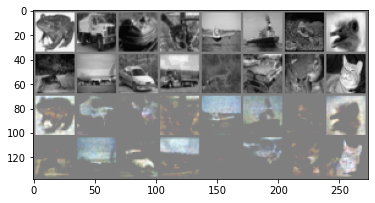

[32, _] epoch train loss: 0.160
[32, _] epoch valid loss: 0.165
Training Mode...
[33,    50] train loss: 0.159
[33,   100] train loss: 0.162
[33,   150] train loss: 0.163
[33,   200] train loss: 0.151
[33,   250] train loss: 0.162
[33,   300] train loss: 0.162
Validation Mode...
[33, _] validation loss: 0.166
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


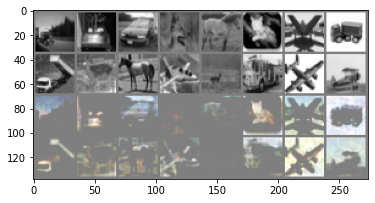

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


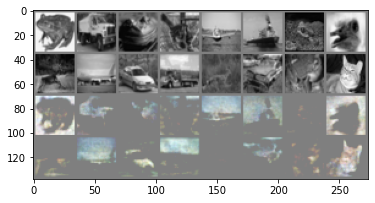

[33, _] epoch train loss: 0.160
[33, _] epoch valid loss: 0.165
Training Mode...
[34,    50] train loss: 0.159
[34,   100] train loss: 0.157
[34,   150] train loss: 0.163
[34,   200] train loss: 0.160
[34,   250] train loss: 0.152
[34,   300] train loss: 0.160
Validation Mode...
[34, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


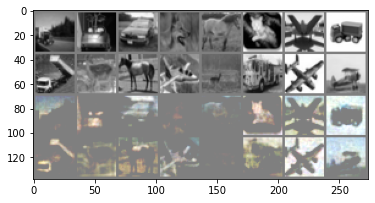

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


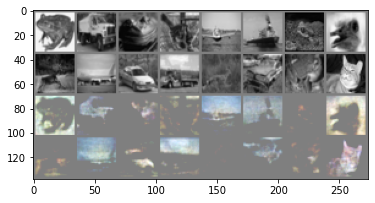

[34, _] epoch train loss: 0.159
[34, _] epoch valid loss: 0.166
Training Mode...
[35,    50] train loss: 0.154
[35,   100] train loss: 0.158
[35,   150] train loss: 0.161
[35,   200] train loss: 0.155
[35,   250] train loss: 0.160
[35,   300] train loss: 0.162
Validation Mode...
[35, _] validation loss: 0.166
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


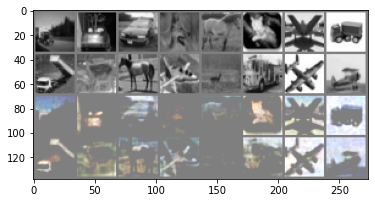

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


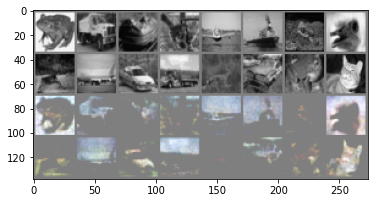

[35, _] epoch train loss: 0.159
[35, _] epoch valid loss: 0.165
Training Mode...
[36,    50] train loss: 0.159
[36,   100] train loss: 0.157
[36,   150] train loss: 0.156
[36,   200] train loss: 0.159
[36,   250] train loss: 0.160
[36,   300] train loss: 0.162
Validation Mode...
[36, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


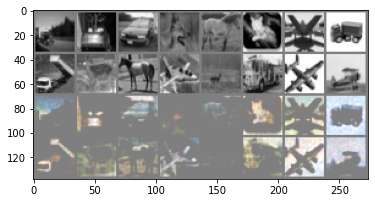

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


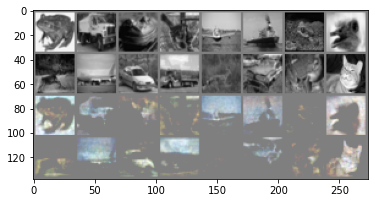

[36, _] epoch train loss: 0.159
[36, _] epoch valid loss: 0.165
Training Mode...
[37,    50] train loss: 0.158
[37,   100] train loss: 0.154
[37,   150] train loss: 0.165
[37,   200] train loss: 0.157
[37,   250] train loss: 0.156
[37,   300] train loss: 0.161
Validation Mode...
[37, _] validation loss: 0.167
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


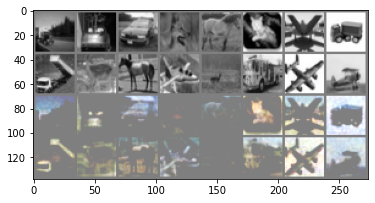

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


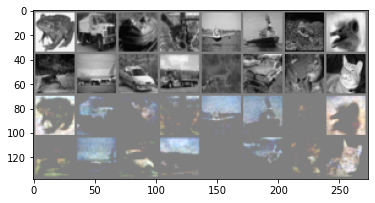

[37, _] epoch train loss: 0.159
[37, _] epoch valid loss: 0.165
Training Mode...
[38,    50] train loss: 0.161
[38,   100] train loss: 0.155
[38,   150] train loss: 0.157
[38,   200] train loss: 0.163
[38,   250] train loss: 0.154
[38,   300] train loss: 0.160
Validation Mode...
[38, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


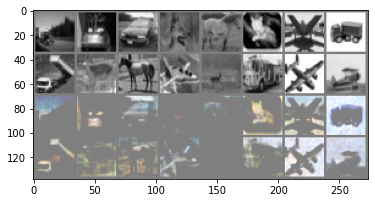

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


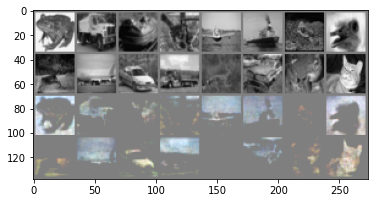

[38, _] epoch train loss: 0.158
[38, _] epoch valid loss: 0.166
Training Mode...
[39,    50] train loss: 0.161
[39,   100] train loss: 0.154
[39,   150] train loss: 0.153
[39,   200] train loss: 0.159
[39,   250] train loss: 0.163
[39,   300] train loss: 0.159
Validation Mode...
[39, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


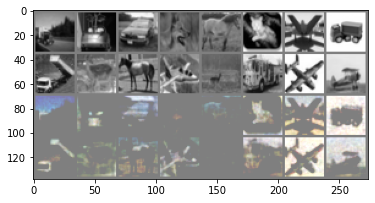

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


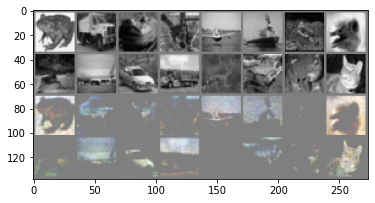

[39, _] epoch train loss: 0.158
[39, _] epoch valid loss: 0.167
Training Mode...
[40,    50] train loss: 0.159
[40,   100] train loss: 0.151
[40,   150] train loss: 0.157
[40,   200] train loss: 0.155
[40,   250] train loss: 0.162
[40,   300] train loss: 0.163
Validation Mode...
[40, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


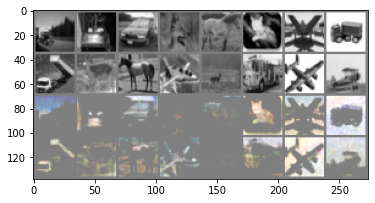

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


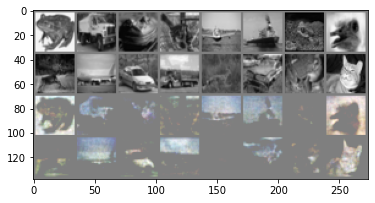

[40, _] epoch train loss: 0.158
[40, _] epoch valid loss: 0.166
Training Mode...
[41,    50] train loss: 0.157
[41,   100] train loss: 0.160
[41,   150] train loss: 0.154
[41,   200] train loss: 0.160
[41,   250] train loss: 0.154
[41,   300] train loss: 0.162
Validation Mode...
[41, _] validation loss: 0.164
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


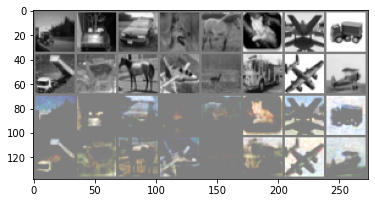

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


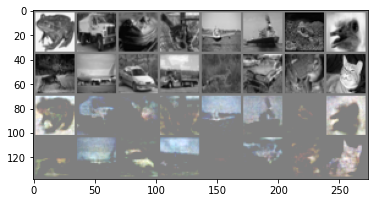

[41, _] epoch train loss: 0.158
[41, _] epoch valid loss: 0.165
Training Mode...
[42,    50] train loss: 0.154
[42,   100] train loss: 0.159
[42,   150] train loss: 0.158
[42,   200] train loss: 0.152
[42,   250] train loss: 0.169
[42,   300] train loss: 0.159
Validation Mode...
[42, _] validation loss: 0.164
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


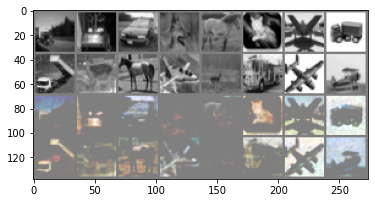

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


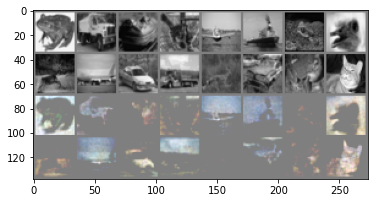

[42, _] epoch train loss: 0.158
[42, _] epoch valid loss: 0.166
Training Mode...
[43,    50] train loss: 0.158
[43,   100] train loss: 0.164
[43,   150] train loss: 0.154
[43,   200] train loss: 0.154
[43,   250] train loss: 0.153
[43,   300] train loss: 0.160
Validation Mode...
[43, _] validation loss: 0.164
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


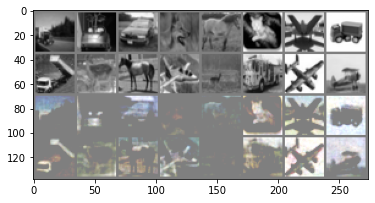

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


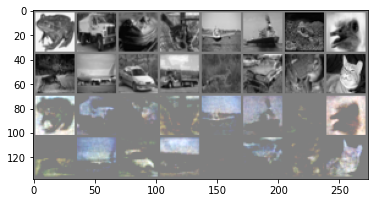

[43, _] epoch train loss: 0.158
[43, _] epoch valid loss: 0.165
Training Mode...
[44,    50] train loss: 0.159
[44,   100] train loss: 0.157
[44,   150] train loss: 0.156
[44,   200] train loss: 0.157
[44,   250] train loss: 0.154
[44,   300] train loss: 0.159
Validation Mode...
[44, _] validation loss: 0.164
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


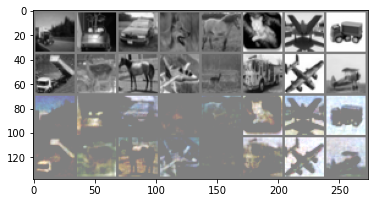

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


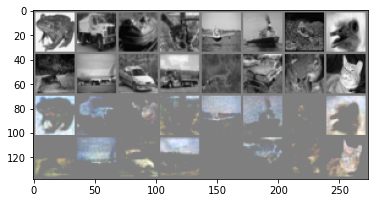

[44, _] epoch train loss: 0.157
[44, _] epoch valid loss: 0.165
Training Mode...
[45,    50] train loss: 0.153
[45,   100] train loss: 0.146
[45,   150] train loss: 0.157
[45,   200] train loss: 0.159
[45,   250] train loss: 0.163
[45,   300] train loss: 0.162
Validation Mode...
[45, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


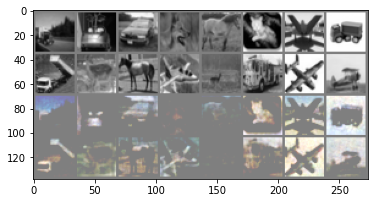

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


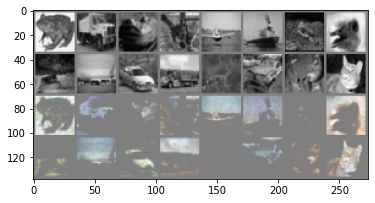

[45, _] epoch train loss: 0.157
[45, _] epoch valid loss: 0.165
Training Mode...
[46,    50] train loss: 0.161
[46,   100] train loss: 0.157
[46,   150] train loss: 0.166
[46,   200] train loss: 0.151
[46,   250] train loss: 0.153
[46,   300] train loss: 0.159
Validation Mode...
[46, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


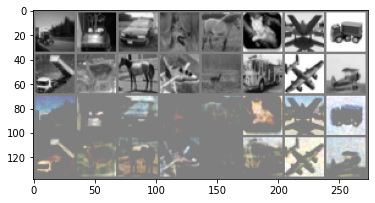

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


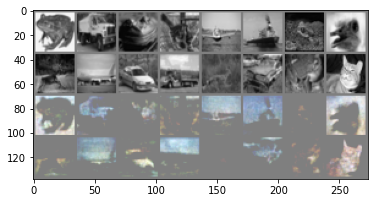

[46, _] epoch train loss: 0.158
[46, _] epoch valid loss: 0.166
Training Mode...
[47,    50] train loss: 0.160
[47,   100] train loss: 0.155
[47,   150] train loss: 0.154
[47,   200] train loss: 0.158
[47,   250] train loss: 0.156
[47,   300] train loss: 0.157
Validation Mode...
[47, _] validation loss: 0.167
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


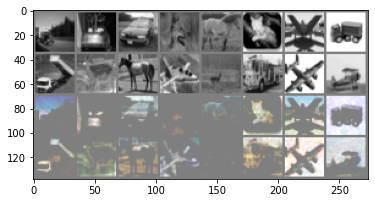

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


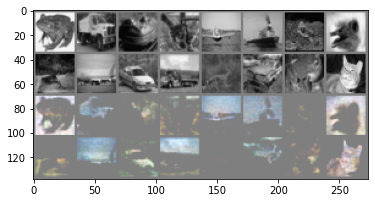

[47, _] epoch train loss: 0.157
[47, _] epoch valid loss: 0.165
Training Mode...
[48,    50] train loss: 0.157
[48,   100] train loss: 0.155
[48,   150] train loss: 0.153
[48,   200] train loss: 0.155
[48,   250] train loss: 0.165
[48,   300] train loss: 0.154
Validation Mode...
[48, _] validation loss: 0.165
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


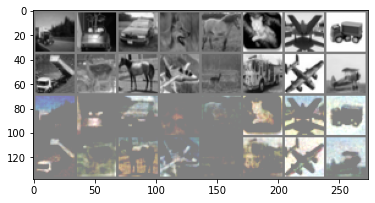

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


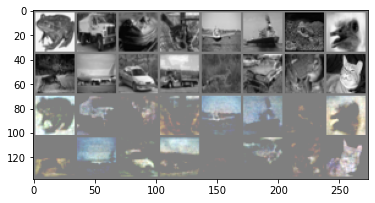

[48, _] epoch train loss: 0.157
[48, _] epoch valid loss: 0.165
Training Mode...
[49,    50] train loss: 0.160
[49,   100] train loss: 0.159
[49,   150] train loss: 0.150
[49,   200] train loss: 0.156
[49,   250] train loss: 0.160
[49,   300] train loss: 0.158
Validation Mode...
[49, _] validation loss: 0.166
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


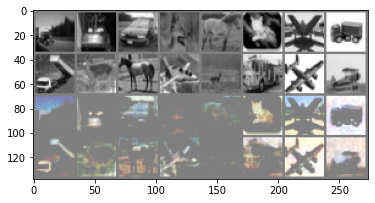

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


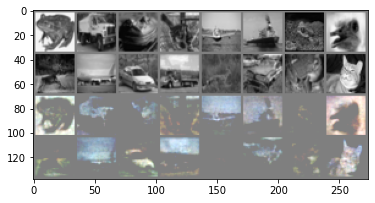

[49, _] epoch train loss: 0.157
[49, _] epoch valid loss: 0.165
Training Mode...
[50,    50] train loss: 0.155
[50,   100] train loss: 0.165
[50,   150] train loss: 0.155
[50,   200] train loss: 0.157
[50,   250] train loss: 0.154
[50,   300] train loss: 0.151
Validation Mode...
[50, _] validation loss: 0.167
inference on train:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


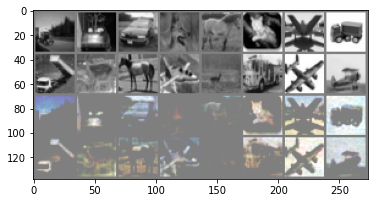

inference on valid:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


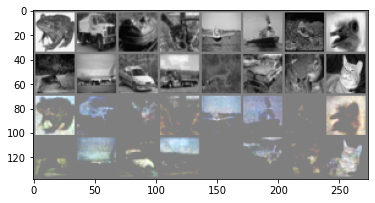

[50, _] epoch train loss: 0.156
[50, _] epoch valid loss: 0.165
Finished Training


In [6]:
history_train_loss = []
history_valid_loss = []
train_epoch_loss = 0
valid_epoch_loss = 0
print("Start training from Epoch: ", prev_epoch+1)
for epoch in range(prev_epoch, prev_epoch+epoch_num):  # loop over the dataset multiple times
    train_running_loss = 0.0
    valid_running_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    print("Training Mode...")
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, _ = data
        images_gray = rgb2gray_batch(images_color)
        
        # flatten and put data into gpu/cpu
        images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
        images_color_flat = images_color.reshape(images_color.shape[0], -1)
        images_gray_flat = images_gray_flat.to(device)
        images_color_flat = images_color_flat.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # Size - images_gray: [batchSize, 1024]
        outputs = model(images_gray_flat)
    
        # Backward
        # Size - images_color_flat: [batchSize,3072]
        # Size - outputs: [batchSize,3072]
        train_loss = criterion(outputs, images_color_flat)
        train_loss.backward()
        optimizer.step()

        # print output statistics
#         train_epoch_loss += train_loss.item()
        train_epoch_loss += train_loss.item()*images_color.shape[0]

        train_running_loss += train_loss.item()
        
        j = 50              # print every j mini-batches
        if i % j == (j-1):     # print every j mini-batches
            print('[%d, %5d] train loss: %.3f' %
                  (epoch + 1, i + 1, train_running_loss / j))
            
            writer.add_scalar('Loss/train', train_running_loss/j, len(trainloader)*epoch + i)
            train_running_loss = 0.0
        
    ###################
    # validate the model #
    ###################
    model.eval()
    print("Validation Mode...")
    with torch.no_grad():
        for k, data in enumerate(validloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            images_color, _ = data
            images_gray = rgb2gray_batch(images_color)

            # flatten and put data into gpu/cpu
            images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
            images_color_flat = images_color.reshape(images_color.shape[0], -1)
            images_gray_flat = images_gray_flat.to(device)
            images_color_flat = images_color_flat.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward
            # Size - images_gray: [batchSize, 1024]
            outputs = model(images_gray_flat)

            # Backward
            # Size - images_color_flat: [batchSize,3072]
            # Size - outputs: [batchSize,3072]
            valid_loss = criterion(outputs, images_color_flat)

            # print output statistics
#             valid_epoch_loss += valid_loss.item()
            valid_epoch_loss += valid_loss.item()*images_color.shape[0]
            
            valid_running_loss += valid_loss.item()
    
        print('[%d, _] validation loss: %.3f' %
              (epoch + 1, valid_running_loss/(k+1)))

        writer.add_scalar('Loss/valid', valid_running_loss/(k+1), len(trainloader)*(epoch+1))
        valid_running_loss = 0.0
        
    # Save the summary and loss, after each epoch
    make_grid(fixed_trainloader, epoch, "train")
    make_grid(fixed_validloader, epoch, "valid")
#     history_train_loss.append(train_epoch_loss/(i+1))
#     history_valid_loss.append(valid_epoch_loss/(k+1))
    history_train_loss.append(train_epoch_loss/len(trainSet))
    history_valid_loss.append(valid_epoch_loss/len(validSet))
    print('[%d, _] epoch train loss: %.3f' %
          (epoch + 1, train_epoch_loss/len(trainSet)))
    print('[%d, _] epoch valid loss: %.3f' %
          (epoch + 1, valid_epoch_loss/len(validSet)))
    train_epoch_loss = 0.0
    valid_epoch_loss = 0.0

    
# write finished epoch nums to txt file
fileEpoch = open("./runs/"+model_name+"/epoch.txt","w") 
fileEpoch.write(str(epoch))
fileEpoch.close()

# clean summary writer
writer.flush()
writer.close()
# plot_writer.flush()
# plot_writer.close()
print('Finished Training')

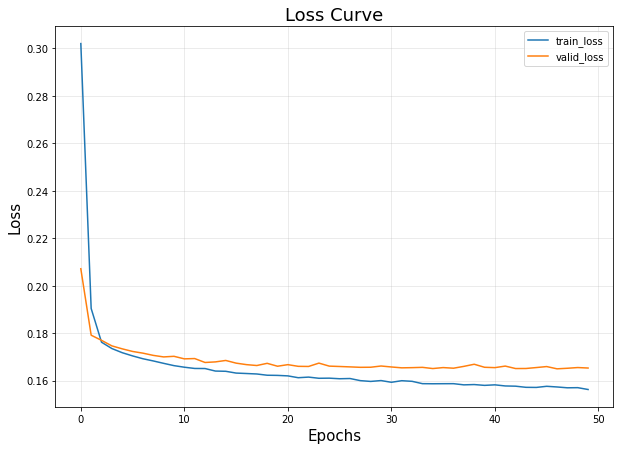

In [7]:
### Plot a graph of Training Loss and Validation Loss together

f = plt.figure(figsize=(10,7))
f.add_subplot()

#Adding Subplot
plt.plot(range(len(history_train_loss)), history_train_loss, label = "train_loss") # Loss curve for training set
plt.plot(range(len(history_valid_loss)), history_valid_loss, label = "valid_loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig("runs/"+model_name+"/Loss_curve.png")
plt.show()

### Inference

In [8]:
def inference(loaderName, prefix):
    print(prefix)
    images_color, _ = next(iter(loaderName))
#     print("images_color: ", images_color.shape)
    images_color_show = images_color.reshape(batchSize,3,32,32)
#     imshow(torchvision.utils.make_grid(images_color_show.detach()), name="inference/"+prefix+"color")

    images_gray = rgb2gray_batch(images_color)
#     print("images_gray: ", images_gray.shape)
    images_gray = images_gray.reshape(batchSize,1,32,32)
#     imshow(torchvision.utils.make_grid(images_gray.detach()), name="inference/"+ prefix+"gray")

    # run inference on the network
    images_gray = images_gray.to(device)
    outputs = model(images_gray)
    outputs = outputs.reshape(batchSize,3,32,32)
    outputs = outputs.to("cpu")
    
    images_gray = images_gray.to("cpu")
    images_gray = torch.cat((images_gray, images_gray, images_gray), 1)
    merged_out = torch.cat((images_color_show, images_gray, outputs),0)
    
    imshow(torchvision.utils.make_grid(merged_out.detach()), name="inference/"+prefix+"_outputs")

train


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


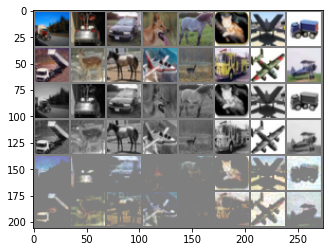

valid


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


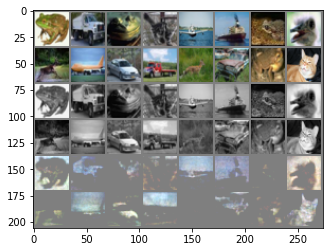

test


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


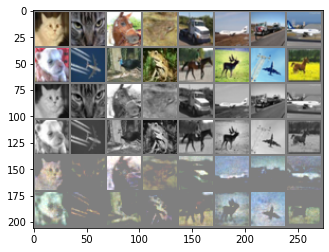

In [9]:
inference(fixed_trainloader, "train")
inference(fixed_validloader, "valid")
inference(fixed_testloader, "test")

### Test the model

In [10]:
###################
# test the model #
###################
model.eval()
test_running_loss = 0.0
print("Test Mode...")
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        images_color, _ = data
        images_gray = rgb2gray_batch(images_color)

        # flatten and put data into gpu/cpu
        images_gray_flat = images_gray.reshape(images_color.shape[0], -1)
        images_color_flat = images_color.reshape(images_color.shape[0], -1)
        images_gray_flat = images_gray_flat.to(device)
        images_color_flat = images_color_flat.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # Size - images_gray: [batchSize, 1024]
        outputs = model(images_gray_flat)

        # Backward
        # Size - images_color_flat: [batchSize,3072]
        # Size - outputs: [batchSize,3072]
        test_loss = criterion(outputs, images_color_flat)

        # print output statistics
        test_running_loss += test_loss.item()

    print('test loss: %.5f' %
          (test_running_loss/(i+1)))

Test Mode...
test loss: 0.15947


### Save the model

In [11]:
if not os.path.exists('./saved_model'):
    os.makedirs('./saved_model')
torch.save(model.state_dict(), model_path)